# `ShapeLinker`: Reinforcement Learning

This notebook demonstrates how to run reinforcement learning for `ShapeLinker` with `Link-INVENT`-infrastructure. This notebook is adapted from [ReinventCommunity](https://github.com/MolecularAI/ReinventCommunity).

In [11]:
# load dependencies
import os
import re
import json
import tempfile

root = os.path.dirname(os.getcwd())
# --------- change these path variables as required
reinvent_dir = os.path.join(root, 'Reinvent')

reinvent_env = os.path.expanduser("/opt/conda/envs/shapelinker")
output_dir = os.path.join(root, "results/RL/5T35_test")
data_folder = os.path.join(root, 'utils/data') 
models_folder = os.path.join(root, 'models')

# if required, generate a folder to store the results
os.makedirs(output_dir, exist_ok=True)

## Setting up the configuration
The `REINVENT` platform (which provides access to `Link-INVENT`) has an entry point that loads a specified `JSON` file on startup. `JSON` is a low-level data format that allows to specify a fairly large number of parameters in a cascading fashion very quickly. The parameters are structured into *blocks* which can in turn contain blocks or simple values, such as *True* or *False*, strings and numbers. In this tutorial, we will go through the different blocks step-by-step, explaining their purpose and potential values for given parameters. Note, that while we will write out the configuration as a `JSON` file in the end, in Python we handle the same information as a simple `dict`.

### 1. Run Type Block

In [12]:
# initialize the dictionary
configuration = {
    "version": 3,
    "model_type": "link_invent",
    "run_type": "reinforcement_learning"
}

### 2. Logging Block
This block specifies output directories for **logging** and **results**, containing the following information:

* **logging**: saves the training progress of the experiment. Visualizing the training log via `tensorboard` which is installed in the provided environment will allow one to monitor the agent's learning progress and to what extent each desired objective is optimized. The training progress can also be monitored during the run to potentially spot early training plateau, in which case, it may be useful to start a new run with different hyperparameters.


* **results**: saves the final results of the experiment. This includes the `scaffold memory` (discussed further at the end of this notebook) which contains all the top scoring compounds generated throughout the run. This `CSV` file allows users to easily parse the top results for downstream processing.

In [13]:
# add block to specify whether to run locally or not and
# where to store the results and logging
configuration["logging"] = {
    "sender": "",                          # only relevant if "recipient" is set to "remote"
    "recipient": "local",                  # either to local logging or use a remote REST-interface
    "logging_frequency": 10,
    "logging_path": os.path.join(output_dir, "progress.log"),  # load this folder in tensorboard to 
                                                               # visualize training progress
    "result_folder": os.path.join(output_dir, "results"),      # output directory for results
    "job_name": "RL",                       # set an arbitrary job name for identification
    "job_id": "N/A"                        # only relevant if "recipient" is set to "remote"
}

### 3. Parameters Block

This block specifies all the experiment parameters. In the cell below, we first set the hyperparameters for `Reinforcement Learning (RL)`, including:

1. `"actor" and "critic"`: These are the paths to a pre-trained `Link-INVENT` generative model. One such model is provided in the /models folder in this repository and named `linkinvent.prior`. This prior is the generative model featured in the `Link-INVENT` manuscript and all details related to its training can be found in the `Supporting Information`. Generally, the `"actor"` and `"critic"` are initialized as the same pre-trained model. 


2. `"warheads"`: This is a list specifiying the 2 molecular sub-units (as SMILES) to link. The `"*"` denotes the attachment point position of each warhead and the warheads are separated using the `"|"` delimiter.


3. `"n_steps"`: This denotes how many epochs to run. Typically this can be set to between 100-200.


4. `"learning_rate"`: This denotes the learning rate. Generally, the default 0.0001 works well.


5. `"batch_size"`: The number of linkers to generate per epoch. The default is 128 but we use 32 as the shape alignment is rather computationally expensive.


6. `"randomize_warhead"`: Denotes whether to obtain a randomized SMILES representation of the warheads at every epoch. Generally, the default "true" works well. Randomizing SMILES increases the generalizability (results may cover a larger `chemical space`).


7. `"learning_strategy"`: This denotes how the `loss function` is constructed. The default `"dap"` strategy and `"sigma" = 120 ` works well. For more information, see the `Link-INVENT` and `Lib-INVENT` manuscripts.

In [14]:
# add the "parameters" block
configuration["parameters"] = {}

configuration["parameters"] = {
    "actor": os.path.join(models_folder, "linkinvent.prior"),   # this pre-trained prior is provided in /models
    "critic": os.path.join(models_folder, "linkinvent.prior"),
    "warheads" :[
            "*C(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1ccc(C2=C(C)NCS2)cc1)C(C)(C)C|*NC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(sc(C)c2C)-n2c(C)nnc21"
            ],
    "n_steps": 1000,   # number of epochs to perform RL
    "learning_rate": 0.0001, 
    "batch_size": 32,  
    "randomize_warheads": True,
    "learning_strategy": {
        "name": "dap", 
        "parameters": {
        "sigma": 120
        }
    }
}

#### Configure the scoring strategy
This includes setting up the `Diversity Filters` (discussed below) and the `Scoring Function` (discussed below).

In [15]:
configuration["parameters"]["scoring_strategy"] = {
    "name": "link_invent" # do not change
}

##### Configure Diversity Filter

The Diversity Filter (DF) offers users the control over agent `exploration` (generating molecules from different `chemical space`) and `exploitation` (generating favourable molecules from similar `chemical space`). There are 3 DFs available in `Link-INVENT`:


1. `"IdenticalMurckoScaffold"`: Penalizes repeated sampling of the same Bemis-Murcko scaffold. An important point to note here is that this effectively operates at the linker level since the 2 warheads are held constant. Thus, this DF ensures diverse linkers are generated.


2. `"NoFilterWithPenalty"`: Penalizes repeated sampling of the same linker. The corresponding linker receives a score scaled by 0.5 (halved).


3. `"NoFilter"`: No penalization.

The notion of "repeated sampling" is governed by the `"bucket_size"` parameter. This denotes the maximum number of permitted linkers corresponding to the choice of DF used. Further sampling of the linker will be penalized. For example, if a linker Bemis-Murcko scaffold (denote it scaffold A) has been sampled 25 times using a `"bucket_size"` of 25, the 26th time scaffold A is sampled, the linker receives a score of 0. This in turn encourages the agent to explore other `chemical space`.

Additional parameters include:


1. `"minscore"`: Denotes the mininum score a linker (and the corresponding linked molecules) must achieve to be saved in the final output (`scaffold memory`). In practice, this can be set to 0.4 so that only linkers that at least moderately satisfy the desired objective is saved. If set to 0, every single linker generated will be saved. This could be useful if one is interested in analyizing the overall sampling behaviour of the agent.


2. `"minsimilarity"`: If using the `"IdenticalMurckoScaffold"`, repeated sampling of the same Bemis-Murcko scaffold is penalized (as explained above). When a new Bemis-Murcko scaffold is generated by the agent, its similarity is compared to all the Bemis-Murcko scaffolds generated thus far. If there has already been a Bemis-Murcko scaffold sampled that possesses a similarity >= `"minsimilarity"`, the new Bemis-Murcko scaffold will populate that `bucket`. For example, consider a Bemis-Murcko scaffold A is sampled 24 times with a `"bucket_size"` of 25. Now consider a new (never seen before) Bemis-Murcko scaffold B is sampled. If B >= `"minsimilarity"`, then B will be added to the `bucket` of A. Subsequently, the next A or B sampled will result in 26 items in the bucket and would thus receive a score of 0 (penalization). This parameter can encourage more `exploration`.

In [16]:
configuration["parameters"]["scoring_strategy"]["diversity_filter"] =  {
      "bucket_size": 25,
      "minscore": 0.4,
      "minsimilarity": 0.6,
      "name": "IdenticalMurckoScaffold"   
}

##### Scoring Function Definition
The Scoring Function is the reward function used to assess the *desirability* of molecules generated via `RL`. An arbitrary number of components (as long as it is supported in the codebase) can be specified in the Scoring Function. Subsequently, the agent gradually learns to generate molecules that satisfy all desired objectives. 

An important consideration is that different components can have different ranges of raw values. These values are normalized in the interval $[0,1]$ such that the `Link-INVENT` agent can properly learn. Scores achieved by each component is aggregated to a `total score` desiring the overall *desirability* of the generated molecules. This is done either by the weighted average sum (`custom_sum`) or by a weighted geometric mean (`custom_product`). It is this `total score` that is used for the agent's policy update in the `RL` loop. For more details on `custom_sum` and `custom_product`, see the notebook in this repository: `Score_Transformations`.

We now discuss how raw component values are normalized in the interval $[0,1]$. A `score transformation` is applied that transforms the raw values based on the defined function. Tuning the parameters of the transformation function allows one to control the agent's learning.

The Scoring Function components below are the ones used for `ShapeLinker`. In order to do RL the shape alignment model and the respective sdf of the query pose is needd. The data used in the corresponding paper are provided in a public storage (see README). 

**`Important`**: Adapt `data_folder` and `alignment_env` accordingly.

In [17]:
scoring_function = {
    "name": "custom_sum",  # either "custom_sum" or "custom_product"
    "parallel": False,  # do not change                   
    
    "parameters": [
      {
      "weight": 1,
      "component_type": "linker_ratio_rotatable_bonds", 
      "name": "ratio rotatable bonds",             
      "specific_parameters": {
      "transformation": {
              "high": 30,
              "low": 0,
              "transformation_type": "step",
              }
           }
      }, 
      {
      "weight": 1,
      "component_type": "linker_length_ratio",
      "name": "linker length ratio",
      "specific_parameters": {
          "transformation": {
              "high": 100,
              "low": 100,
              "transformation_type": "step"
              }
            }
      },
    # add component: surface alignment scoring
    {
        "component_type": "linker_shape_scoring",
        "name": "shape_alignment_score",
        "weight": 3,
        "specific_parameters": {
            "query": os.path.join(data_folder, "xtal_poses/5T35/5T35_fragments/5T35_linker_extended.sdf"),
            "query_type": "sdf",
            "model_path": os.path.join(models_folder, "protacdb_extlinker_model_align.pth"),
            # XXX path to the python executable in the shape_align environment
            "alignment_env": "/opt/conda/envs/shape_align/bin/python",
            "poses_folder": os.path.join(output_dir, "poses"),
            # XXX extract and align on the extended linker (should match the input query)
            "get_ext_linker": True,
            # XXX resample during alignment until 90% of batch have a low RMSD in bimodal distribution (increases runtime)
            "correct_flipping": True,
            "num_conformers": 16,
            "transformation": {
                "transformation_type": "reverse_sigmoid", # squish into range [0,1] (the lower the value, the higher the score)
                "high": 3.5, 
                "low": 0,
                "k": 0.25  # steepness of the sigmoid
        }}
    }
      ]
}

configuration["parameters"]["scoring_strategy"]["scoring_function"] = scoring_function

The dictionary has now been initialized with all parameters necessary to run `Link-INVENT`. Next, we write it out as a `JSON` which will serve as the `Configuration JSON` to run `Link-INVENT`.

In [18]:
# write out the configuration to disc
configuration_JSON_path = os.path.join(output_dir, "RL_Configuration.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(configuration, f, indent=4, sort_keys=False)

The `Configuration JSON` is saved to the `output_dir` specified in the beginning of this notebook.

# Run
Execute `Link-INVENT` directly in this jupyter notebook

In [55]:
%%capture captured_err_stream --no-stderr

# execute from the command-line
!{reinvent_env}/bin/python {reinvent_dir}/input.py {configuration_JSON_path}

In [56]:
# print the output to a file, just to have it for documentation
with open(os.path.join(output_dir, "run.err"), 'w') as file:
    file.write(captured_err_stream.stdout)

Execute in command line
```
# activate environment
$ conda activate shapelinker

# execute in command line
$ python <reinvent_dir>/input.py <configuration_JSON_path>
```

## Analyse the results

In order to analyze the run in a more intuitive way, we can use `tensorboard`:

```
# go to the root folder of the output
$ cd <output_dir>

# activate the environment
$ conda activate shapelinker

# start tensorboard
$ tensorboard --logdir "progress.log"
```

Then copy the link provided to a browser window. The following figures are example plots - there is always some randomness involved. The `tensorboard` plots display both the individual scoring function components and the average overall score.

## Scaffold Memory: where the top compounds generated are saved
All valid compounds with scores over 0.4 can be found in the `scaffold_memory.csv` file.The SMILES are ranked by their total scores from high to low. 

**note: scaffold_memory.csv contains SMILES, Scaffolds, Scores from different components and Total score.**

First, we show a few lines of the `scaffold_memory.csv`.

In [12]:
# import needed packages
import pandas as pd

scaffold_memory_path = os.path.join(output_dir, 'results/scaffold_memory.csv')
df = pd.read_csv(scaffold_memory_path)
df.head()

,Step,Scaffold,SMILES,linker,input,ratio rotatable bonds,effective linker length,linker length ratio,QED,raw_ratio rotatable bonds,raw_effective linker length,raw_linker length ratio,total_score,ID
0,219.0,O=C(NCC(=O)N1CCCC1C(=O)NC(CCCCC#CCCC#CCc1ccc(N...,Cc1ncsc1-c1ccc(C(CCCCC#CCCC#CCc2ccc(N(C(=O)c3c...,[*]CCCCC#CCCC#CC[*],Cc1ncsc1-c1ccc(C(*)NC(C2N(C(C(C(C)(C)C)NC(C3(F...,1.0,1.0,1.0,0.043305,30.0,10.0,100.0,0.808661,default_job_0
1,108.0,O=C(NCC(=O)N1CCCC1C(=O)NC(C#CCc1ccc(N(C(=O)c2c...,Cc1c(C(=O)N(c2ccccc2)c2ccc(CC#CC(NC(=O)C3CC(O)...,[*]C#CC[*],C(C(=O)N1C(C(NC(*)c2ccc(-c3ccnn3C3CC3)cc2)=O)C...,1.0,0.0,1.0,0.090229,0.0,2.0,100.0,0.618046,default_job_1
2,16.0,O=C(NCC(=O)N1CCCC1C(=O)NC(CC#Cc1ccc(N(C(=O)c2c...,Cc1c(C(=O)N(c2ccccc2)c2ccc(C#CCC(NC(=O)C3CC(O)...,[*]CC#C[*],C1C(n2c(-c3ccc(C(NC(C4CC(O)CN4C(=O)C(NC(C4(F)C...,1.0,0.0,1.0,0.090218,0.0,2.0,100.0,0.618044,default_job_2
3,17.0,O=C(NCC(=O)N1CCCC1C(=O)NC(CCc1ccc(N(C(=O)c2c[n...,Cc1c(C(=O)N(c2ccccc2)c2ccc(CCC(NC(=O)C3CC(O)CN...,[*]CC[*],FC1(C(=O)NC(C(N2C(C(=O)NC(*)c3ccc(-c4ccnn4C4CC...,1.0,0.0,1.0,0.085687,0.0,1.0,100.0,0.617137,default_job_3
4,15.0,O=C(NCC(=O)N1CCCC1C(=O)NC(CCc1ccc(N(C(=O)c2c[n...,Cc1ncsc1-c1ccc(C(CCc2ccc(N(C(=O)c3cc(-c4cc(Cl)...,[*]CC[*],OC1CN(C(C(NC(=O)C2(F)CC2)C(C)(C)C)=O)C(C(=O)NC...,1.0,0.0,1.0,0.085208,0.0,1.0,100.0,0.617042,default_job_4


Next, we show a few example molecules.

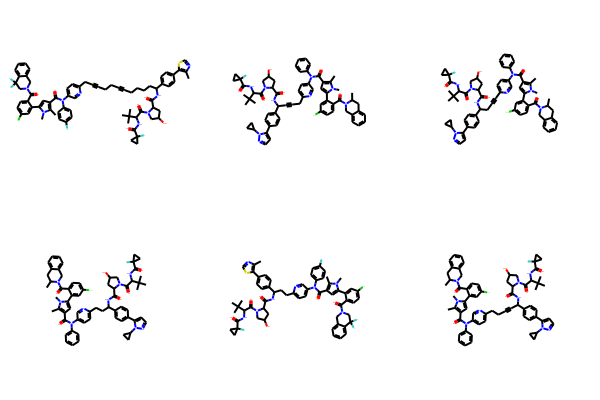

In [13]:
# import needed packages
from rdkit import Chem
from rdkit.Chem import Draw

smile_list = df['SMILES'][:6].to_list() # change the number here to show more/less top compounds
mols = [Chem.MolFromSmiles(smiles) for smiles in smile_list]
Draw.MolsToGridImage(mols)